# Semantic interpretation.

Semantic interpretation is a NLP technique to draw the meaning of a text/sentence. In this implementation, we will focuse on determining two sentences in different languages (english and spanish) have the same meaning.

Some possible sentences for our dataset are:

- Woman buys new car & Mujer compra coche nuevo (1)
- Man buys blue car & Mujer compra coche azul (0)
- Woman buys new car & Mujer compra automóvil nuevo (1)
- Man buys new car & Hombre compra automóvil viejo (0)
- Woman buys old car & Mujer adquiere coche viejo (1)
- Woman buys new car & Mujer hurta coche nuevo (0)
- Woman buys new car & Mujer roba coche rojo (0)
- Woman steals red car & Mujer roba coche rojo (0)
...

Where each example follows this structure: Sentence in english & Sentence in spanish (meaning coincidence label).

Our dataset is built using this vocabulary:


| Subject | Verbs | Objects | Adjectives | | Nombres | Verbos | Objetos | Adjetivos |
| --- | --- | --- | --- | | --- | --- | --- | --- |
| Woman | steals | car | old | | Mujer | roba | coche | viejo |
| Man | buys | sofa | new | | Hombre | hurta | automóvil | nuevo |
|  | purchases | coach | red | |  | compra | sillón | azul |
|  | breaks | notebook | blue | |  | rompe | cuaderno | rojo |


The proposed vocabulary has 14 words and two different kind of sentences for each language:
- Subject + Verb + Object (32 sentences)
- Subject + Verb + (Adj +) Object (128 sentences)

This makes 160 sentences per language and hence 25600
possible combinations.

## 1. Create dataset


### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have three types of words: nouns, adjectives, verbs (transitive). We also distinguish two different types of nouns: objects and subjects. 

In [63]:
import numpy as np
import pickle

In [78]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns (subjects)
man, woman = Word('man', n), Word('woman', n)
mujer, hombre = Word('mujer', n), Word('hombre', n)
# nouns (objects)
car, sofa, coach, notebook = Word('car', n), Word('sofa', n), Word('coach', n), Word('notebook', n)
coche, automovil, sillon, cuaderno = Word('coche', n), Word('automovil', n), Word('sillon', n), Word('cuaderno', n)
# adjectives
old, new, red, blue = Word('old', n @ n.l), Word('new', n @ n.l), Word('red', n @ n.l), Word('blue', n @ n.l)
viejo, nuevo, rojo, azul = Word('viejo', n.r @ n), Word('nuevo', n.r @ n ), Word('rojo', n.r @ n), Word('azul', n.r @ n )
# Transitive verbs
buys, purchases, steals, breaks  = Word('buys', n.r @ s @ n.l), Word('purchases', n.r @ s @ n.l), Word('steals', n.r @ s @ n.l), Word('breaks', n.r @ s @ n.l)
compra, roba, hurta, rompe  = Word('compra', n.r @ s @ n.l), Word('roba', n.r @ s @ n.l), Word('hurta', n.r @ s @ n.l), Word('rompe', n.r @ s @ n.l)

subjects = [man, woman]
sujetos = [mujer, hombre]
verbs = [buys, purchases, steals, breaks]
verbos = [compra, roba, hurta, rompe]
adjectives = [old, new, red, blue]
adjetivos = [viejo, nuevo, rojo, azul]
objects = [car, sofa, coach, notebook]
objetos = [coche,  sillon, automovil, cuaderno]


vocab_E = subjects + verbs + adjectives + objects 
vocab_S = sujetos + verbos + adjetivos + objetos

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- noun + t. verb + noun



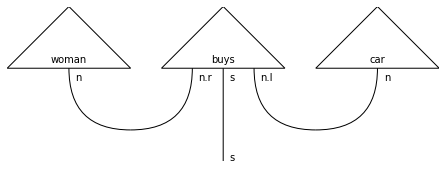

In [79]:
from discopy import Cup, Id, pregroup

grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ buys @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + adjective + noun (for english)

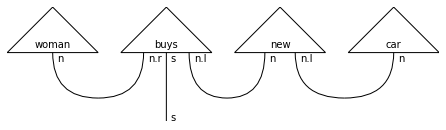

In [80]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n)
sentence = woman @ buys @ new @ car >> grammar
pregroup.draw(sentence)

- noun + t. verb + noun +adjective (for spanish)

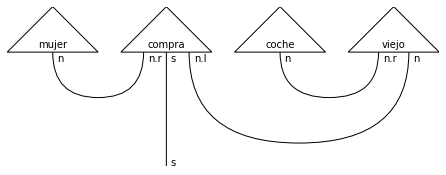

In [81]:
grammar =  Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)
sentence = mujer @ compra @ coche @ viejo >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [82]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}                                                                   

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# English noun+verb+noun sentences
parsing_NVNe = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in subjects for verb in verbs for obj in objects}
sentences_NVNe = list(parsing_NVNe.keys())
for sentence in sentences_NVNe:
    diagram = parsing_NVNe[sentence]
    data_psr[sentence] = parsing_NVNe[sentence]
    
# Spanish noun+verb+noun sentences
parsing_NVNs = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in sujetos for verb in verbos for obj in objetos}
sentences_NVNs = list(parsing_NVNs.keys())
for sentence in sentences_NVNs:
    diagram = parsing_NVNs[sentence]
    data_psr[sentence] = parsing_NVNs[sentence]
    
# English noun+verb+adjective+noun sentences
parsing_NVANe = {"{} {} {} {}.".format(subj, verb, adj, obj): subj @ verb @ adj @ obj  >> grammar_dict['NVAN']
            for subj in subjects  for verb in verbs for adj in adjectives for obj in objects}
sentences_NVANe = list(parsing_NVANe.keys())
for sentence in sentences_NVANe:
    diagram = parsing_NVANe[sentence]
    data_psr[sentence] = parsing_NVANe[sentence]
    
# Spanish noun+verb+noun+adjectives sentences
parsing_NVNAs = {"{} {} {} {}.".format(subj, verb, obj, adj): subj @ verb @ obj @ adj  >> grammar_dict['NVNA']
            for subj in sujetos for verb in verbos for obj in objetos  for adj in adjetivos}
sentences_NVNAs = list(parsing_NVNAs.keys())
for sentence in sentences_NVNAs:
    diagram = parsing_NVNAs[sentence]
    data_psr[sentence] = parsing_NVNAs[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. Therefore, the next step is to manually modify the .txt to select some sentences for the dataset and asign each pair of different language sentences a label to distinguish wether they have the same meaning (1) or different meanings (0). In order to do that we will create three .txt files: on efor the english sentences, other for the spanish sentences and a last one assigning the corresponding label to the selected sentence combinations.

In [83]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary   
grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}  
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)
#English
data_file_eng = open('rawfulldataset_SI_eng.txt', 'w')

# English noun+verb+noun sentences
parsing_NVNe = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in subjects for verb in verbs for obj in objects}
sentences_NVNe = list(parsing_NVNe.keys())

#Write the separate .txt for each language.
for sentence_e in sentences_NVNe:
    with open('./rawfulldataset_SI_eng.txt', 'a') as f:
        f.write(sentence_e + '\n')
        
# English noun+verb+adjective+noun sentences
parsing_NVANe = {"{} {} {} {}.".format(subj, verb, adj, obj): subj @ verb @ adj @ obj  >> grammar_dict['NVAN']
            for subj in subjects  for verb in verbs for adj in adjectives for obj in objects}
sentences_NVANe = list(parsing_NVANe.keys())

#Write the separate .txt for each language.
for sentence_e in sentences_NVANe:
    with open('./rawfulldataset_SI_eng.txt', 'a') as f:
        f.write(sentence_e + '\n')
        
data_file_eng.close()        

In [84]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary   
grammar_dict = {
    'NVN' :  Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'NVAN' : Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n),
    'NVNA' : Cup(n, n.r) @ Id (s @ n.l) @ Cup(n, n.r) @ Id(n) >> Id(s) @ Cup(n.l, n) >> Id(s)}  
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)
#English
data_file_spa = open('rawfulldataset_SI_spa.txt', 'w')

# English noun+verb+noun sentences
parsing_NVNs = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj  >> grammar_dict['NVN']
            for subj in sujetos for verb in verbos for obj in objetos}
sentences_NVNs = list(parsing_NVNs.keys())

#Write the separate .txt for each language.
for sentence_s in sentences_NVNs:
    with open('./rawfulldataset_SI_spa.txt', 'a') as f:
        f.write(sentence_s + '\n')
        
# English noun+verb+adjective+noun sentences
parsing_NVNAs = {"{} {} {} {}.".format(subj, verb, obj, adj): subj @ verb @ obj @ adj  >> grammar_dict['NVNA']
            for subj in sujetos  for verb in verbos for adj in adjetivos for obj in objetos}
sentences_NVNAs = list(parsing_NVNAs.keys())

#Write the separate .txt for each language.
for sentence_s in sentences_NVNAs:
    with open('./rawfulldataset_SI_spa.txt', 'a') as f:
        f.write(sentence_s + '\n')
        
data_file_spa.close()   

Now we have to manually delete the extra sentences and asign the label. In case that we don't want to take into account a pair of sentences we will label the combination 'x'.

In [1]:
#Create .txt to store the relation between phrases in each rawfulldatase_SI_language.txt.
#We are going to keep 14 NVN phrases for language, 39 NVAN and 51 NVNA.
with open('TrainingSet_SI_eng_reduced.txt') as f:
    data_eng = f.readlines()
with open('TrainingSet_SI_spa_reduced.txt') as g:
    data_spa = g.readlines()  

data_file_labels = open('loquesea.txt', 'w')

for sentences_e in data_eng:
    sentences_e = sentences_e.replace('\n', '')
    for sentences_s in data_spa:
        sentences_s = sentences_s.replace('\n', '')
        with open('loquesea.txt', 'a') as h:
            h.write(sentences_e+'_'+sentences_s+'_x'+'\n')

data_file_labels.close()

Here we check that everything is correct in the dataset.

In [6]:
with open ('TrainingSet_labels_reduced.txt') as f:
    data = f.readlines()

labels_dict = {}
true = 0
false = 0

for sentence in data:
    if sentence[-2] == '0':
        print(sentence)
        false += 1
    elif sentence[-2] == '1':
        print(sentence)
        true += 1
        
print('Number of same meaning sentences combinations:', true)
print('Number of different meaning sentence combinations:', false)

man buys car._hombre compra coche._1

man buys car._hombre roba coche._0

man buys sofa._hombre compra sillon._1

man buys sofa._hombre rompe sillon._0

man buys notebook._mujer compra cuaderno._0

man buys notebook._hombre compra coche._0

man buys notebook._hombre compra sillon._0

man buys notebook._hombre compra cuaderno._1

man steals sofa._hombre roba sillon._1

man steals sofa._hombre rompe sillon._0

man steals notebook._mujer compra cuaderno._0

man steals notebook._hombre compra cuaderno._0

man steals notebook._hombre roba coche._0

man steals notebook._hombre roba cuaderno._1

man breaks notebook._hombre rompe cuaderno._1

woman buys car._mujer compra coche._1

woman buys car._mujer roba coche._0

woman buys sofa._mujer compra sillon._1

woman buys sofa._mujer compra cuaderno._0

woman buys notebook._mujer compra cuaderno._1

woman steals car._mujer compra coche._0

woman steals car._mujer roba coche._1

woman steals car._hombre rompe coche._0

woman steals sofa._mujer roba